In [50]:
# import dataset

import os
import cv2
import numpy as np

LR_DIR = 'Data/LR/'
HR_DIR = 'Data/HR/'

def get_data():
    lr_images = []
    hr_images = []
    for file in os.listdir(LR_DIR):
        try:
            lr = cv2.imread(LR_DIR + file)
            hr = cv2.imread(HR_DIR + file)
            lr_images.append(lr)
            hr_images.append(hr)
        except:
            pass
    return lr_images, hr_images

lr_images, hr_images = get_data()

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

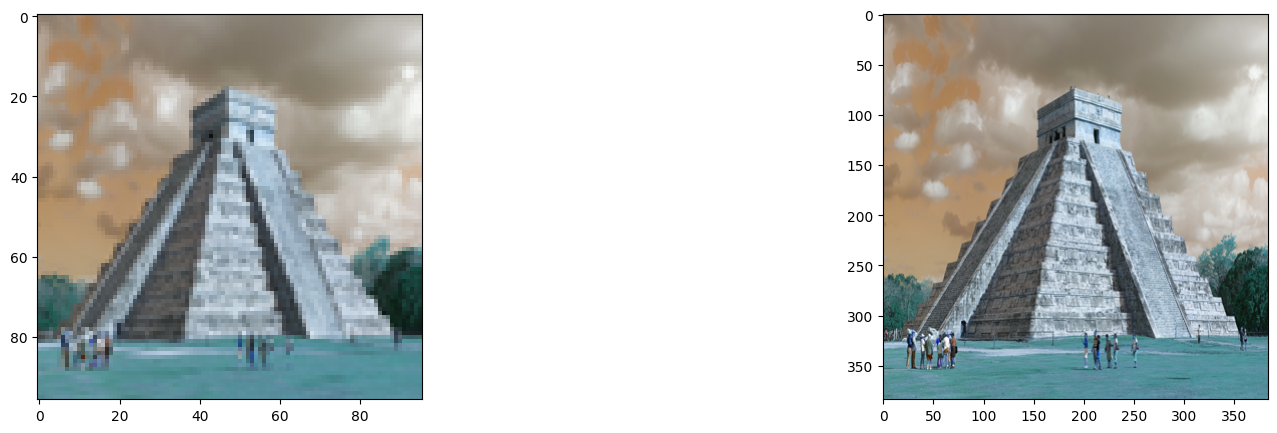

In [51]:
# plotting frist image in dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.imshow(lr_images[0])
plt.subplot(1, 2, 2)
plt.imshow(hr_images[0])
plt.show()

In [52]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [53]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

In [54]:
def res_block(ip):
    x = layers.Conv2D(64, (3, 3), padding='same')(ip)
    x = layers.BatchNormalization(momentum=0.5)(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization(momentum=0.5)(x)
    m = layers.Add()([ip, x])
    return m

In [55]:
def upscale_block(ip):
    x = layers.Conv2D(256, (3, 3), padding='same')(ip)
    x = layers.UpSampling2D(size=2)(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    return x

In [56]:
def create_gen(gen_ip, num_res_block):
    l = layers.Conv2D(64, (9, 9), padding='same')(gen_ip)
    l = layers.PReLU(shared_axes=[1, 2])(l)
    temp = l
    for i in range(num_res_block):
        l = res_block(l)
    l = layers.Conv2D(64, (3, 3), padding='same')(l)
    l = layers.BatchNormalization(momentum=0.5)(l)
    l = layers.Add()([l, temp])
    l = upscale_block(l)
    l = upscale_block(l)
    l = layers.Conv2D(3, (9, 9), padding='same')(l)
    return models.Model(gen_ip, op)

In [57]:
def discriminator_block(ip, filters, strides=1, bn=True):
    disc_model = layers.Conv2D(filters, (3,3), strides=strides, padding='same')(ip)
    if bn:
        disc_model = layers.BatchNormalization(momentum=0.5)(disc_model)
    disc_model = layers.LeakyReLU(alpha=0.2)(disc_model)
    return disc_model

In [58]:
def create_disc(disp_ip):
    df = 8
    l = discriminator_block(disp_ip, df, bn=False)
    l = discriminator_block(l, df, strides=2)
    l = discriminator_block(l, df*2)
    l = discriminator_block(l, df*2, strides=2)
    l = discriminator_block(l, df*4)
    l = discriminator_block(l, df*4, strides=2)
    l = discriminator_block(l, df*8)
    l = discriminator_block(l, df*8, strides=2)

    l = layers.Flatten()(l)
    l = layers.Dense(df*16)(l)
    l = layers.LeakyReLU(alpha=0.2)(l)
    l = layers.Dense(1, activation='sigmoid')(l)
    return models.Model(disp_ip, l)

In [59]:
from keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", input_shape=hr_shape, include_top=False)
    return models.Model(vgg.input, vgg.layers[10].output)

In [60]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_image = gen_model(lr_ip)
    gen_features = vgg(gen_image)
    disc_model.trainable = False
    disc_op = disc_model(gen_image)
    return models.Model([lr_ip, hr_ip], [disc_op, gen_features])

In [61]:
lr_images = lr_images.astype('float32') / 255.0
hr_images = hr_images.astype('float32') / 255.0

lr_images, val_lr_images, hr_images, val_hr_images = train_test_split(lr_images, hr_images, test_size=0.3, random_state=42)

In [62]:
hr_shape = hr_images[0].shape
lr_shape = lr_images[0].shape

In [63]:
lr_input = layers.Input(shape=lr_shape)
hr_input = layers.Input(shape=hr_shape)

generator = create_gen(lr_input, 8)
generator.summary()

discriminator = create_disc(hr_input)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_29 (Conv2D)             (None, 96, 96, 64)   15616       ['input_4[0][0]']                
                                                                                                  
 p_re_lu_11 (PReLU)             (None, 96, 96, 64)   64          ['conv2d_29[0][0]']              
                                                                                                  
 conv2d_30 (Conv2D)             (None, 96, 96, 64)   36928       ['p_re_lu_11[0][0]']             
                                                                                            

In [64]:
vgg = build_vgg(hr_shape)
vgg.trainable = False
print(vgg.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 384, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 384, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 192, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 192, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 192, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 96, 128)       0   

In [65]:
gan_model = create_comb(generator, discriminator, vgg, lr_input, hr_input)

In [66]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 384, 384, 3)  1448835     ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 1)            4793385     ['model_4[0][0]']          

In [104]:
batch_size = 5
train_lr_batches = []
train_hr_batches = []
for it in range(int(lr_images.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_images[start_idx:end_idx])
    train_lr_batches.append(lr_images[start_idx:end_idx])

In [68]:
from tqdm import tqdm

In [115]:
epochs = 40

for epoch in range(epochs):
    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size, 1))

    g_losses = []
    d_losses = []

    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]

        fake_imgs = generator.predict(lr_imgs)

        discriminator.trainable = True
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        discriminator.trainable = False

        d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

        iamge_features = vgg.predict(hr_imgs)

        g_loss, _,_ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, iamge_features])

        g_losses.append(g_loss)
        d_losses.append(d_loss)
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    print("Epoch: {}/{} Discriminator Loss: {} Generator Loss: {}".format(epoch+1, epochs, d_loss, g_loss))

  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 1/14 [00:02<00:27,  2.13s/it]

1/1 [==============================] - 0s 96ms/step


 14%|█▍        | 2/14 [00:04<00:27,  2.26s/it]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 3/14 [00:06<00:21,  2.00s/it]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 4/14 [00:07<00:19,  1.90s/it]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 5/14 [00:09<00:16,  1.81s/it]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 6/14 [00:11<00:13,  1.74s/it]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.71s/it]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.82s/it]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 9/14 [00:16<00:09,  1.84s/it]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 10/14 [00:18<00:07,  1.78s/it]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 11/14 [00:20<00:05,  1.74s/it]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.71s/it]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 13/14 [00:23<00:01,  1.69s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 14/14 [00:24<00:00,  1.78s/it]


Epoch: 1/40 Discriminator Loss: [0.01253382 0.99285714] Generator Loss: 27.30150740487235


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1/14 [00:01<00:25,  1.99s/it]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 2/14 [00:04<00:24,  2.06s/it]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 3/14 [00:05<00:20,  1.86s/it]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 4/14 [00:07<00:17,  1.77s/it]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.71s/it]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.72s/it]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.72s/it]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.70s/it]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 9/14 [00:16<00:09,  1.84s/it]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 10/14 [00:18<00:07,  1.85s/it]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.80s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.75s/it]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 13/14 [00:23<00:01,  1.71s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


Epoch: 2/40 Discriminator Loss: [0.038531   0.99285714] Generator Loss: 27.41775417327881


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1/14 [00:01<00:20,  1.59s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2/14 [00:03<00:21,  1.77s/it]

1/1 [==============================] - 0s 52ms/step


 21%|██▏       | 3/14 [00:05<00:21,  1.96s/it]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.84s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.77s/it]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.71s/it]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.68s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.75s/it]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 9/14 [00:16<00:09,  1.86s/it]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 10/14 [00:18<00:07,  1.97s/it]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 11/14 [00:20<00:05,  1.92s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.81s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 13/14 [00:23<00:01,  1.74s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 14/14 [00:24<00:00,  1.78s/it]


Epoch: 3/40 Discriminator Loss: [0.00186244 1.        ] Generator Loss: 27.66722665514265


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1/14 [00:01<00:24,  1.88s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2/14 [00:03<00:23,  1.98s/it]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 3/14 [00:05<00:21,  1.99s/it]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.87s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:09<00:15,  1.78s/it]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.71s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.69s/it]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.70s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.73s/it]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.77s/it]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.79s/it]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 13/14 [00:23<00:01,  1.76s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


Epoch: 4/40 Discriminator Loss: [7.08992327e-04 1.00000000e+00] Generator Loss: 27.965966497148788


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1/14 [00:01<00:20,  1.60s/it]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 3/14 [00:04<00:17,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.60s/it]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 5/14 [00:08<00:16,  1.78s/it]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.76s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 7/14 [00:11<00:12,  1.74s/it]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.72s/it]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.70s/it]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 10/14 [00:16<00:06,  1.68s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 11/14 [00:18<00:04,  1.65s/it]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.80s/it]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.81s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


Epoch: 5/40 Discriminator Loss: [4.64451794e-04 1.00000000e+00] Generator Loss: 27.727962357657297


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1/14 [00:01<00:22,  1.73s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.64s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 3/14 [00:04<00:17,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.64s/it]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.74s/it]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 6/14 [00:10<00:15,  1.89s/it]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.82s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.74s/it]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.72s/it]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.68s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 11/14 [00:18<00:04,  1.65s/it]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.62s/it]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.73s/it]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


Epoch: 6/40 Discriminator Loss: [3.10478638e-04 1.00000000e+00] Generator Loss: 27.46538475581578


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1/14 [00:01<00:20,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2/14 [00:03<00:18,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 3/14 [00:04<00:17,  1.57s/it]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 4/14 [00:06<00:15,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:07<00:14,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 6/14 [00:09<00:12,  1.58s/it]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 7/14 [00:11<00:12,  1.76s/it]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.75s/it]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 10/14 [00:17<00:07,  1.81s/it]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.73s/it]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.69s/it]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 13/14 [00:21<00:01,  1.68s/it]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


Epoch: 7/40 Discriminator Loss: [3.49775834e-04 1.00000000e+00] Generator Loss: 26.96909373147147


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1/14 [00:02<00:26,  2.02s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2/14 [00:03<00:22,  1.87s/it]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 3/14 [00:05<00:19,  1.75s/it]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:08<00:14,  1.66s/it]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.64s/it]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 7/14 [00:11<00:11,  1.62s/it]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 8/14 [00:13<00:09,  1.67s/it]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.69s/it]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 10/14 [00:16<00:06,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.67s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 13/14 [00:21<00:01,  1.63s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


Epoch: 8/40 Discriminator Loss: [3.0245102e-04 1.0000000e+00] Generator Loss: 26.97441223689488


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.63s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2/14 [00:03<00:21,  1.78s/it]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 3/14 [00:05<00:21,  1.92s/it]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 4/14 [00:07<00:17,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.75s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.83s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.75s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.69s/it]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.66s/it]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 10/14 [00:17<00:07,  1.81s/it]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.80s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.76s/it]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.70s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


Epoch: 9/40 Discriminator Loss: [2.75123374e-04 1.00000000e+00] Generator Loss: 27.100535529000418


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 3/14 [00:05<00:19,  1.79s/it]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.81s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.73s/it]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.68s/it]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 7/14 [00:11<00:11,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 8/14 [00:13<00:09,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.62s/it]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 10/14 [00:16<00:06,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.72s/it]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.76s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.72s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


Epoch: 10/40 Discriminator Loss: [5.15611195e-04 1.00000000e+00] Generator Loss: 26.676959446498326


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1/14 [00:01<00:20,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2/14 [00:03<00:18,  1.58s/it]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 3/14 [00:04<00:18,  1.65s/it]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.66s/it]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.72s/it]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.75s/it]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 7/14 [00:11<00:11,  1.69s/it]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.67s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 9/14 [00:14<00:08,  1.64s/it]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 10/14 [00:16<00:06,  1.62s/it]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 11/14 [00:18<00:04,  1.60s/it]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 12/14 [00:19<00:03,  1.69s/it]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.83s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


Epoch: 11/40 Discriminator Loss: [4.1887816e-04 1.0000000e+00] Generator Loss: 26.376792362758092


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.60s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 3/14 [00:04<00:17,  1.62s/it]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 5/14 [00:08<00:14,  1.64s/it]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 6/14 [00:09<00:13,  1.65s/it]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 7/14 [00:11<00:12,  1.82s/it]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.75s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.70s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 10/14 [00:16<00:06,  1.67s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 11/14 [00:18<00:04,  1.65s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 12/14 [00:19<00:03,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 13/14 [00:21<00:01,  1.61s/it]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


Epoch: 12/40 Discriminator Loss: [2.37730929e-04 1.00000000e+00] Generator Loss: 26.505972862243652


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1/14 [00:02<00:27,  2.15s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2/14 [00:03<00:21,  1.80s/it]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 3/14 [00:05<00:18,  1.70s/it]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.66s/it]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 5/14 [00:08<00:14,  1.64s/it]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.63s/it]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 7/14 [00:11<00:11,  1.62s/it]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.81s/it]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.74s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.70s/it]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.71s/it]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.86s/it]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 14/14 [00:24<00:00,  1.77s/it]


Epoch: 13/40 Discriminator Loss: [3.68276282e-04 1.00000000e+00] Generator Loss: 26.67121982574463


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1/14 [00:02<00:28,  2.19s/it]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 2/14 [00:03<00:22,  1.88s/it]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 3/14 [00:05<00:19,  1.75s/it]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 4/14 [00:07<00:16,  1.68s/it]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 5/14 [00:08<00:14,  1.64s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.66s/it]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 7/14 [00:11<00:11,  1.65s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.74s/it]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.77s/it]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.71s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.78s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.71s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.72s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


Epoch: 14/40 Discriminator Loss: [7.23495252e-04 1.00000000e+00] Generator Loss: 25.862549100603378


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1/14 [00:01<00:25,  1.98s/it]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2/14 [00:04<00:24,  2.07s/it]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 3/14 [00:05<00:20,  1.90s/it]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.84s/it]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 5/14 [00:09<00:15,  1.75s/it]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.70s/it]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.68s/it]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 8/14 [00:13<00:09,  1.64s/it]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 9/14 [00:16<00:08,  1.78s/it]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 10/14 [00:17<00:07,  1.80s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.73s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.69s/it]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.66s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


Epoch: 15/40 Discriminator Loss: [4.19320818e-04 1.00000000e+00] Generator Loss: 25.35073130471366


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.68s/it]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2/14 [00:03<00:21,  1.83s/it]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 3/14 [00:05<00:21,  1.98s/it]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.90s/it]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 5/14 [00:09<00:16,  1.78s/it]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.73s/it]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.69s/it]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 8/14 [00:13<00:09,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.73s/it]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.73s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.70s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.67s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


Epoch: 16/40 Discriminator Loss: [3.75753108e-04 1.00000000e+00] Generator Loss: 24.94433089665004


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.62s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.66s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 3/14 [00:04<00:18,  1.65s/it]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.67s/it]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.69s/it]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.72s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 7/14 [00:11<00:11,  1.67s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.69s/it]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.70s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 10/14 [00:16<00:06,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 11/14 [00:18<00:04,  1.64s/it]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.75s/it]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


Epoch: 17/40 Discriminator Loss: [3.90550851e-04 1.00000000e+00] Generator Loss: 24.42248616899763


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.63s/it]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 3/14 [00:04<00:18,  1.68s/it]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.75s/it]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 6/14 [00:10<00:15,  1.89s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 7/14 [00:12<00:13,  1.93s/it]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.82s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.76s/it]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.74s/it]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.69s/it]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.65s/it]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.79s/it]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


Epoch: 18/40 Discriminator Loss: [2.34840605e-04 1.00000000e+00] Generator Loss: 24.316968509129115


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.65s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.63s/it]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 3/14 [00:04<00:17,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 4/14 [00:06<00:15,  1.60s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 5/14 [00:08<00:14,  1.63s/it]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.75s/it]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 7/14 [00:12<00:13,  1.86s/it]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.80s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.73s/it]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.70s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.68s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.66s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 13/14 [00:21<00:01,  1.63s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


Epoch: 19/40 Discriminator Loss: [2.79998515e-04 1.00000000e+00] Generator Loss: 24.210952486310685


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1/14 [00:01<00:24,  1.89s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2/14 [00:03<00:20,  1.71s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 3/14 [00:05<00:18,  1.70s/it]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 4/14 [00:06<00:17,  1.71s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.68s/it]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.68s/it]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 7/14 [00:11<00:11,  1.67s/it]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.82s/it]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 9/14 [00:15<00:09,  1.82s/it]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 10/14 [00:17<00:07,  1.76s/it]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.81s/it]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.74s/it]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.69s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


Epoch: 20/40 Discriminator Loss: [3.33479242e-04 1.00000000e+00] Generator Loss: 24.31338950565883


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1/14 [00:02<00:27,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 2/14 [00:04<00:23,  2.00s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 3/14 [00:05<00:19,  1.80s/it]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 4/14 [00:07<00:17,  1.77s/it]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.71s/it]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.67s/it]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.67s/it]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 8/14 [00:13<00:09,  1.64s/it]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.68s/it]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.74s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.71s/it]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.67s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.69s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


Epoch: 21/40 Discriminator Loss: [2.71985575e-04 1.00000000e+00] Generator Loss: 24.300310816083634


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1/14 [00:01<00:22,  1.70s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2/14 [00:03<00:21,  1.81s/it]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 3/14 [00:05<00:20,  1.90s/it]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.75s/it]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.72s/it]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.73s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.74s/it]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.73s/it]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 10/14 [00:17<00:07,  1.78s/it]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.81s/it]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.76s/it]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.75s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


Epoch: 22/40 Discriminator Loss: [4.23876768e-04 1.00000000e+00] Generator Loss: 24.602726118905203


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1/14 [00:01<00:20,  1.60s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 3/14 [00:05<00:19,  1.77s/it]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 4/14 [00:07<00:19,  1.91s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:08<00:16,  1.80s/it]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.72s/it]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.75s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.71s/it]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.70s/it]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.84s/it]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.82s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.75s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


Epoch: 23/40 Discriminator Loss: [6.65738428e-04 1.00000000e+00] Generator Loss: 24.0166072845459


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1/14 [00:01<00:22,  1.70s/it]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2/14 [00:03<00:20,  1.69s/it]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 3/14 [00:05<00:20,  1.85s/it]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.87s/it]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5/14 [00:09<00:16,  1.87s/it]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.79s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.75s/it]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.73s/it]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.69s/it]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.69s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.68s/it]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.79s/it]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.80s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


Epoch: 24/40 Discriminator Loss: [5.33422601e-04 1.00000000e+00] Generator Loss: 23.60276017870222


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.66s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 3/14 [00:04<00:18,  1.65s/it]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.62s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 5/14 [00:08<00:14,  1.65s/it]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.77s/it]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 7/14 [00:11<00:12,  1.76s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.72s/it]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 10/14 [00:16<00:06,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.68s/it]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.70s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 13/14 [00:21<00:01,  1.67s/it]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


Epoch: 25/40 Discriminator Loss: [4.35067814e-04 1.00000000e+00] Generator Loss: 23.217344556535995


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1/14 [00:01<00:22,  1.74s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2/14 [00:03<00:20,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 3/14 [00:05<00:18,  1.69s/it]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.69s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.76s/it]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.76s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.83s/it]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.82s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.76s/it]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.71s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.69s/it]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.67s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.64s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


Epoch: 26/40 Discriminator Loss: [7.00031973e-04 1.00000000e+00] Generator Loss: 23.3666501726423


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1/14 [00:02<00:27,  2.13s/it]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2/14 [00:03<00:22,  1.89s/it]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 3/14 [00:05<00:20,  1.82s/it]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 4/14 [00:07<00:17,  1.73s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.68s/it]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.65s/it]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 8/14 [00:13<00:09,  1.66s/it]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.74s/it]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 10/14 [00:17<00:07,  1.76s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.70s/it]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.69s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.67s/it]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


Epoch: 27/40 Discriminator Loss: [4.02333532e-04 1.00000000e+00] Generator Loss: 23.736797877720424


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.64s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.61s/it]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 3/14 [00:05<00:20,  1.83s/it]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 4/14 [00:07<00:17,  1.79s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.76s/it]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.70s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 7/14 [00:11<00:11,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.67s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.68s/it]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.69s/it]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.83s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.76s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.71s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


Epoch: 28/40 Discriminator Loss: [4.10653765e-04 1.00000000e+00] Generator Loss: 23.896435465131486


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 1/14 [00:01<00:22,  1.75s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2/14 [00:03<00:20,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 3/14 [00:04<00:18,  1.64s/it]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.83s/it]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5/14 [00:08<00:16,  1.85s/it]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.81s/it]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.74s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.74s/it]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.74s/it]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.71s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.77s/it]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.88s/it]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 13/14 [00:23<00:01,  1.81s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 14/14 [00:24<00:00,  1.77s/it]


Epoch: 29/40 Discriminator Loss: [0.00173447 1.        ] Generator Loss: 23.395875113351003


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.65s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.64s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 3/14 [00:04<00:17,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.61s/it]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.76s/it]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.80s/it]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.75s/it]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.73s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.73s/it]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.72s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.71s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.76s/it]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.88s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


Epoch: 30/40 Discriminator Loss: [0.00136496 1.        ] Generator Loss: 23.5925931930542


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.64s/it]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2/14 [00:03<00:20,  1.70s/it]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 3/14 [00:05<00:18,  1.72s/it]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.66s/it]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.70s/it]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.75s/it]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.79s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.77s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.73s/it]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.70s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 11/14 [00:18<00:04,  1.67s/it]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.64s/it]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.75s/it]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


Epoch: 31/40 Discriminator Loss: [2.56810955e-04 1.00000000e+00] Generator Loss: 22.871511459350586


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.67s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2/14 [00:03<00:20,  1.71s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 3/14 [00:04<00:18,  1.65s/it]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 4/14 [00:06<00:17,  1.74s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.69s/it]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.66s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 7/14 [00:11<00:12,  1.74s/it]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.77s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.73s/it]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.70s/it]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.67s/it]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.73s/it]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


Epoch: 32/40 Discriminator Loss: [3.61755112e-04 1.00000000e+00] Generator Loss: 22.95739691598075


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1/14 [00:02<00:27,  2.13s/it]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2/14 [00:03<00:22,  1.90s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 3/14 [00:05<00:19,  1.79s/it]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 4/14 [00:07<00:17,  1.73s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.68s/it]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.67s/it]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.65s/it]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.76s/it]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.73s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.65s/it]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.65s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


Epoch: 33/40 Discriminator Loss: [3.7878106e-04 1.0000000e+00] Generator Loss: 22.91341631753104


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.65s/it]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 2/14 [00:03<00:22,  1.85s/it]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3/14 [00:05<00:20,  1.85s/it]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 4/14 [00:07<00:17,  1.76s/it]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.70s/it]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.85s/it]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.82s/it]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 8/14 [00:14<00:10,  1.76s/it]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 9/14 [00:16<00:09,  1.84s/it]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 10/14 [00:18<00:07,  1.91s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.82s/it]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.77s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 13/14 [00:23<00:01,  1.73s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 14/14 [00:24<00:00,  1.77s/it]


Epoch: 34/40 Discriminator Loss: [3.03013547e-04 1.00000000e+00] Generator Loss: 22.5231751033238


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.64s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.63s/it]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 3/14 [00:05<00:20,  1.85s/it]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.85s/it]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.75s/it]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.71s/it]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.69s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 8/14 [00:13<00:09,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.64s/it]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 10/14 [00:17<00:07,  1.90s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.91s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 12/14 [00:21<00:03,  1.83s/it]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 13/14 [00:23<00:01,  1.79s/it]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


Epoch: 35/40 Discriminator Loss: [0.00323135 1.        ] Generator Loss: 22.429184913635254


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.68s/it]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 2/14 [00:03<00:19,  1.64s/it]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 3/14 [00:04<00:17,  1.62s/it]

1/1 [==============================] - 0s 43ms/step


 29%|██▊       | 4/14 [00:07<00:18,  1.82s/it]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 5/14 [00:08<00:16,  1.84s/it]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.76s/it]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.71s/it]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.68s/it]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.67s/it]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.67s/it]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 11/14 [00:18<00:04,  1.65s/it]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.79s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.78s/it]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


Epoch: 36/40 Discriminator Loss: [0.055423   0.98571429] Generator Loss: 22.456256321498326


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1/14 [00:01<00:21,  1.66s/it]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2/14 [00:03<00:20,  1.70s/it]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 3/14 [00:05<00:18,  1.69s/it]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.66s/it]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 5/14 [00:08<00:16,  1.83s/it]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 6/14 [00:10<00:14,  1.85s/it]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.78s/it]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.73s/it]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.71s/it]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.70s/it]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.67s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.68s/it]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.83s/it]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


Epoch: 37/40 Discriminator Loss: [0.01079472 0.99285714] Generator Loss: 22.282955987112864


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1/14 [00:01<00:23,  1.77s/it]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2/14 [00:03<00:21,  1.77s/it]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 3/14 [00:05<00:18,  1.70s/it]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.68s/it]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 5/14 [00:08<00:14,  1.65s/it]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.72s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 7/14 [00:12<00:12,  1.75s/it]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.72s/it]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.72s/it]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.72s/it]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.77s/it]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.77s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.81s/it]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 14/14 [00:24<00:00,  1.77s/it]


Epoch: 38/40 Discriminator Loss: [7.29845854e-04 1.00000000e+00] Generator Loss: 22.55303450993129


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1/14 [00:01<00:22,  1.76s/it]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2/14 [00:03<00:20,  1.69s/it]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 3/14 [00:05<00:18,  1.66s/it]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 4/14 [00:06<00:16,  1.63s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 5/14 [00:08<00:14,  1.62s/it]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 6/14 [00:09<00:12,  1.62s/it]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 7/14 [00:11<00:12,  1.73s/it]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 8/14 [00:13<00:10,  1.78s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.72s/it]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 10/14 [00:16<00:06,  1.69s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 11/14 [00:18<00:05,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.66s/it]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 13/14 [00:21<00:01,  1.66s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


Epoch: 39/40 Discriminator Loss: [0.00127459 1.        ] Generator Loss: 22.36390781402588


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1/14 [00:02<00:28,  2.17s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2/14 [00:03<00:23,  1.95s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 3/14 [00:05<00:19,  1.81s/it]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 4/14 [00:07<00:17,  1.76s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 5/14 [00:08<00:15,  1.71s/it]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 6/14 [00:10<00:13,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 7/14 [00:12<00:11,  1.64s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 8/14 [00:13<00:09,  1.65s/it]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 9/14 [00:15<00:08,  1.72s/it]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 10/14 [00:17<00:06,  1.72s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 11/14 [00:19<00:05,  1.73s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 12/14 [00:20<00:03,  1.70s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 13/14 [00:22<00:01,  1.67s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 14/14 [00:23<00:00,  1.71s/it]

Epoch: 40/40 Discriminator Loss: [9.20341155e-04 1.00000000e+00] Generator Loss: 22.300949505397252


In [118]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [71]:
# from keras.models import load_model
# from numpy.random import randint

# loaded_generator = load_model('generator.h5', compile=False)

In [128]:
generated_hr_images = generator.predict(val_lr_images)

1/1 [==============================] - 0s 42ms/step


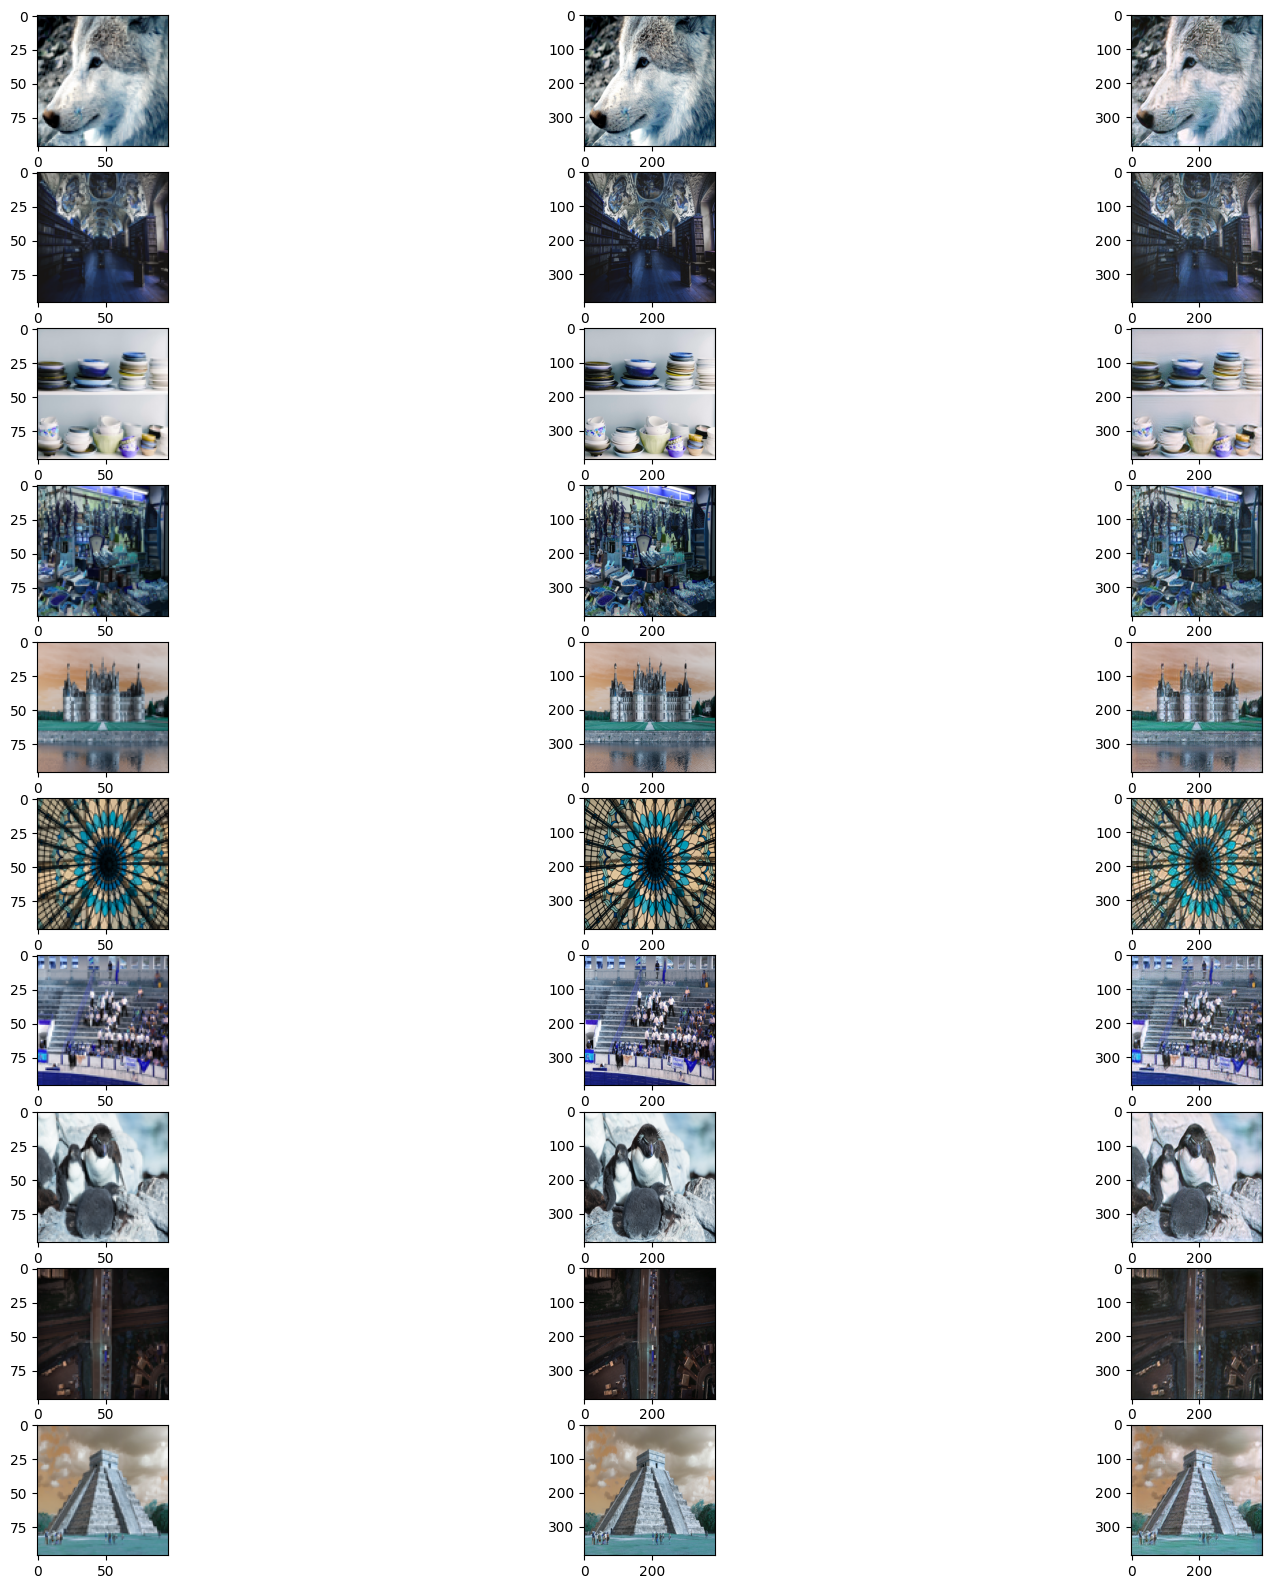

In [130]:
# plot 10 images from validation set and their generated counterparts
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(10, 3, 3*i+1)
    plt.imshow(val_lr_images[i])
    plt.subplot(10, 3, 3*i+2)
    plt.imshow(val_hr_images[i])
    plt.subplot(10, 3, 3*i+3)
    plt.imshow(generated_hr_images[i])

# TODO: Fix some errors in the visualization of the generated images